# Notebook to Start Pulling it All Together

## Salinity top 5 m

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [3]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X2 = X**2
    X2 = X**2
    X3 = X**3
    X4 = X**4
    X5 = X**5
    X6 = X**6
    X = np.column_stack((X, X2, X3, X4, X5, X6))
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    # print (model.params)
    return predictions, model.params['x2'], model.params['x1'], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    if 'ferry' in pieces[0]:
        temp1['k'] = 1.5
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 1.5
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [10]:
def plot_and_stats(temp1, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 34
    vmin = 0
    condition = temp1.k < 5
    title = 'Salinity top 5 m'
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[condition], temp1.mod_vosaline[condition], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[condition], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[condition], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[condition], 'SA', 'mod_vosaline')
    predictions, m2, m, c, syst, nonsyst = slope_inter(temp1[condition], 'SA', 'mod_vosaline')
    tspread = spread(temp1[condition], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(temp1.SA[condition], predictions, 'r.');
    ax.arrow(3, 27, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(3, 29, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 27, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 29, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 27, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 29, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(3-0.2, 22, 'bias', rotation=90)
    ax.text(4-0.2, 21, 'systematic', rotation=90)
    ax.text(5-0.2, 20, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, {title}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [11]:
pieces = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,454676,1.7,5.0,0.21,0.014,1.1e+01,3.6,3.4,0.48


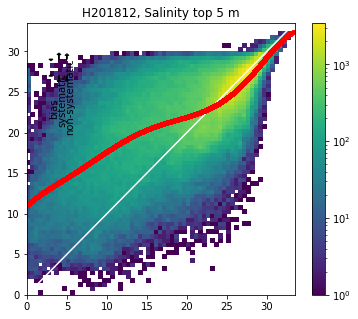

In [12]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201812 = plot_and_stats(temp1, 'H201812')
d201812.style.format(myformat)

In [13]:
pieces = ('/home/sallen/202007/H201905/ObsModel_H201905_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,454676,1.6,5.0,0.21,0.63,1.1e+01,3.5,3.4,0.47


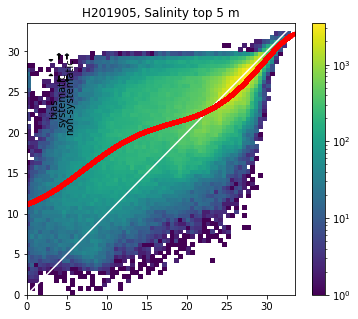

In [14]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201905 = plot_and_stats(temp1, 'H201905')
d201905.style.format(myformat)

In [15]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150101_20150331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150401_20150630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150701_20150930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20151001_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160101_20160331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160301_20160630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160601_20160930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20161001_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170101_20170331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170401_20170630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170701_20170930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20171001_20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,458001,1.7,5.0,0.21,0.069,1.1e+01,3.6,3.4,0.48


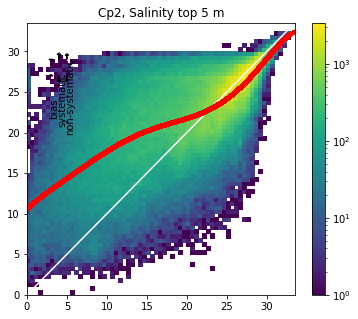

In [16]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
dCp2 = plot_and_stats(temp1, 'Cp2')
dCp2.style.format(myformat)

In [17]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20170101_20171231.csv'
        )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,454616,1.6,5.0,0.21,0.39,1.1e+01,3.6,3.4,0.47


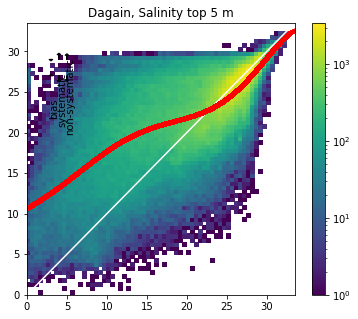

In [18]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
Dagain = plot_and_stats(temp1, 'Dagain')
Dagain.style.format(myformat)

In [19]:
pieces = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv',         
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20150101_20151231.csv',     
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20170101_20171231.csv')

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-noCil,454676,1.7,5.1,0.22,-0.041,1.1e+01,3.7,3.4,0.49


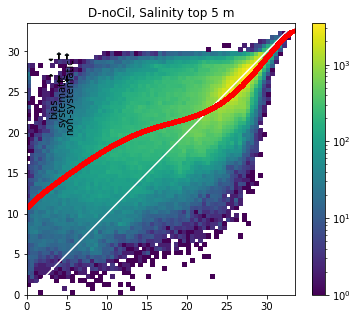

In [20]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DnoC = plot_and_stats(temp1, 'D-noCil')
DnoC.style.format(myformat)

In [21]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20170101_20171231.csv')

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,454676,1.6,5.0,0.22,0.38,1.1e+01,3.6,3.4,0.48


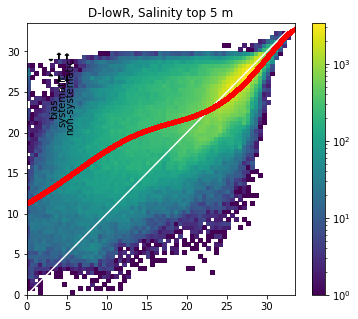

In [22]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DlowR = plot_and_stats(temp1, 'D-lowR')
DlowR.style.format(myformat)

In [25]:
pieces = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20160101_20161231.csv',
          '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TSPUG_20150101-20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20160101_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20160101_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150101_20150331.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150401_20150630.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150701_20150930.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20151001_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160101_20160331.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160401_20160630.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160701_20160930.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20161001_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20170101_20171231.csv')

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp3,452174,1.9,5.0,0.21,0.38,1.1e+01,3.7,3.3,0.49


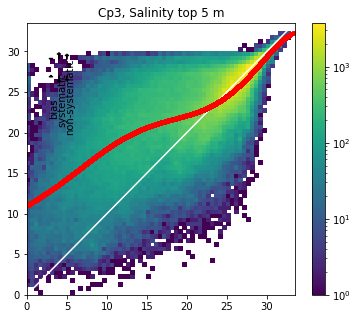

In [26]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modCp3 = plot_and_stats(temp1, 'Cp3')
modCp3.style.format(myformat)

In [27]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv')

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,454676,1.9,5.1,0.22,0.26,1.1e+01,3.7,3.3,0.5


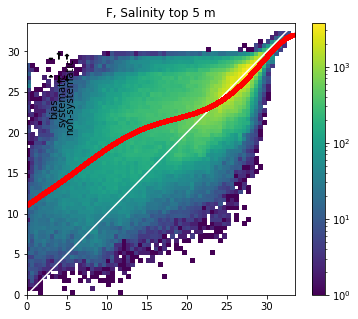

In [28]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modF = plot_and_stats(temp1, 'F')
modF.style.format(myformat)

In [29]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [31]:
alltogether = pd.concat([d201905, dCp2, Dagain, DnoC, DlowR, modCp3, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,454676,1.6,5.0,0.21,0.63,1.1e+01,3.5,3.4,0.47
Cp2,458001,1.7,5.0,0.21,0.069,1.1e+01,3.6,3.4,0.48
Dagain,454616,1.6,5.0,0.21,0.39,1.1e+01,3.6,3.4,0.47
D-noCil,454676,1.7,5.1,0.22,-0.041,1.1e+01,3.7,3.4,0.49
D-lowR,454676,1.6,5.0,0.22,0.38,1.1e+01,3.6,3.4,0.48
Cp3,452174,1.9,5.0,0.21,0.38,1.1e+01,3.7,3.3,0.49
F,454676,1.9,5.1,0.22,0.26,1.1e+01,3.7,3.3,0.5


So adding the ferry data, the new river files actually make things worse from the ferry point of view.  Primarily the bias is higher, suggesting the plume has moved more "away" from the ferry.

2.0534137179540797 1.972631482953616
const    16.231397
x1       -0.095949
x2        0.018382
dtype: float64


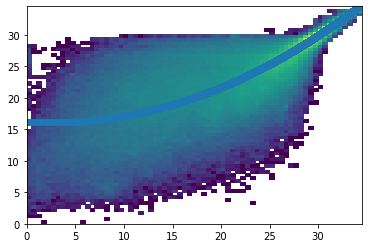

In [40]:

temp1.mod_vosaline
X = temp1.SA
X2 = X**2
X = np.column_stack((X, X2))
X = sm.add_constant(X)
y = temp1.mod_vosaline

model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X)
nonsyst = np.sqrt(((y - predictions)**2).mean())
systematic = np.sqrt(((predictions - temp1.SA)**2).mean())
print(nonsyst, systematic)
plt.hist2d(temp1.SA, temp1.mod_vosaline, bins=np.arange(0, 35, 0.5), norm=LogNorm())
plt.plot(temp1.SA, predictions, 'o')
print (model.params)

3.4444597195598616 3.6186670836802977
const    1.067833e+01
x1       9.311238e-01
x2      -7.582070e-02
x3       1.159907e-02
x4      -8.773853e-04
x5       2.846280e-05
x6      -3.227669e-07
dtype: float64


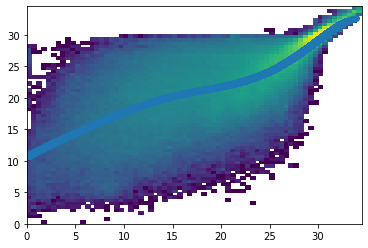

In [48]:
condition = temp1.k < 5
X = temp1.SA[condition]
X2 = X**2
X3 = X**3
X4 = X**4
X5 = X**5
X6 = X**6
X = np.column_stack((X, X2, X3, X4, X5, X6))
X = sm.add_constant(X)
y = temp1.mod_vosaline[condition]

model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X)
nonsyst = np.sqrt(((y - predictions)**2).mean())
systematic = np.sqrt(((predictions - temp1.SA[condition])**2).mean())
print(nonsyst, systematic)
plt.hist2d(temp1.SA, temp1.mod_vosaline, bins=np.arange(0, 35, 0.5), norm=LogNorm())
plt.plot(temp1.SA[condition], predictions, 'o')
print (model.params)

In [ ]:
X = 
    y = df[mod]
#    X = np.column_stack((X.values, X.values**2))
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst